# Head Velocity
Notebook for clean attempt of checking the distribution of head velocity including the direction.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, integrate, signal

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i]    = pd.read_hdf(path+x+'_filter.h5', 'Full')
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      

# Pick the experiment number
i = 2


In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df


def angle_orig(df):
    V1 = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])
    V2 = np.array([1       , 0       , 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['thetaOrig'] = np.arccos(CosTheta)
    return df


def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


## Single experiment analysis
Mergning event log and filetered data from experiment. Removing useless columns. Calculating the flattened vector in XZ plane (lx1, lz1) - including sing, and normalization to unitvector lenght. 

In [3]:
dfV = pd.merge(event[i], df[i], on='Frame')

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)


In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

dfV.dropna(inplace=True)


## Angle and Velocity
Calculating the angle between orientation 2D vector and origin set to XZ(1,0). Substracting the angles between iterations to calculate change of angle in each iteration. Based on that: dV = dTheta / dTime

In [5]:
# calculatinig the angles between X axis and the vectors
dfV = dfV.apply(angle_orig, axis=1) # calculation between two vectors(does not include direction) -  theta
dfV = dfV.apply(angle_zero, axis=1) # calculation with origin

dfV['theta1'] = dfV.theta0.shift(1)
dfV['theta'] = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)
dfV.drop({'theta0','theta1'}, axis=1, inplace=True)



In [6]:
# angular velocity
dfV['U']     = dfV.apply(lambda row: np.degrees(row.theta)     / row.dTime, axis=1) #between two vectors velocity
dfV['UOrig'] = dfV.apply(lambda row: np.degrees(row.thetaOrig) / row.dTime, axis=1)
dfV.dropna(inplace=True)


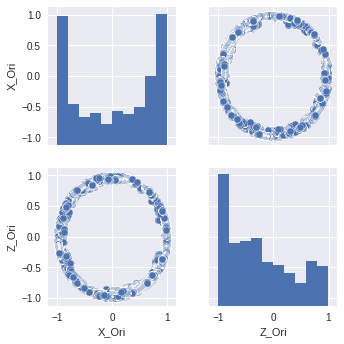

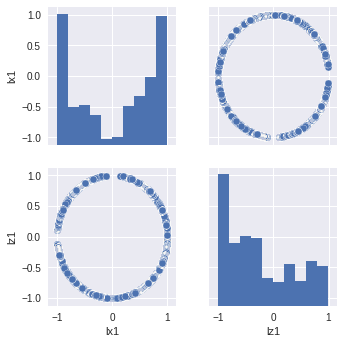

In [7]:
# plotting original X, Y and new vector
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['X_Ori', 'Z_Ori'])

fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

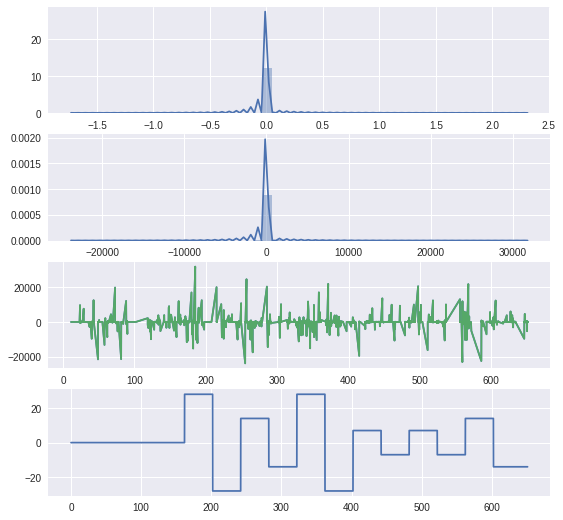

In [8]:
# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c1 = ax3.plot(dfV.Time, dfV.U)
e1 = ax4.plot(event[i].Time, event[i].speed)


## Filtering velocity values

In [9]:
# Pick the hyperparameters for analysis
hyperparam = { 'windowSize': 30 ,
               'limitDT'   : 0.1,
               'limitVAng' : 100,
               'DmaxPerc'  : 0.2,}

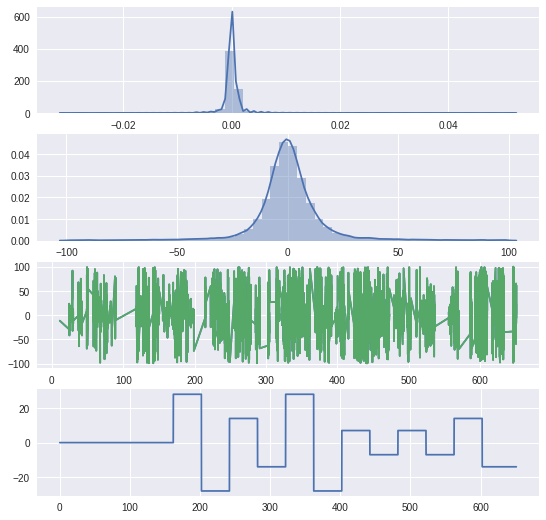

In [10]:
# U and theta distributions with limited velocity
dfV  = dfV[dfV['dTime'] < hyperparam['limitDT']]

dfV = dfV[dfV['U'] < hyperparam['limitVAng']]
dfV = dfV[dfV['U'] >-hyperparam['limitVAng']]

# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c1 = ax3.plot(dfV.Time, dfV.U)
#c1 = ax3.plot(dfV.Time, dfV.U)
e1 = ax4.plot(event[i].Time, event[i].speed)


## Angular velocity analysis
Comparison of velocity logged per even with calculated velocit (substraction and correlation). Addtional smoothing of the data applied.

In [11]:
#smoothing the data
dfV['M']     = dfV['U'].rolling(window=hyperparam['windowSize']).mean()

# substraction
dfV['subU']  = dfV.apply(lambda row: row.speed - row.U, axis=1)
dfV['subM']  = dfV.apply(lambda row: row.speed - row.M, axis=1)

# correlation
dfV['corr']  = signal.correlate(dfV.speed, dfV.U, mode='same') / 128
dfV['corrM'] = signal.correlate(dfV.speed, dfV.M, mode='same') / 128

#print(dfV.corr)

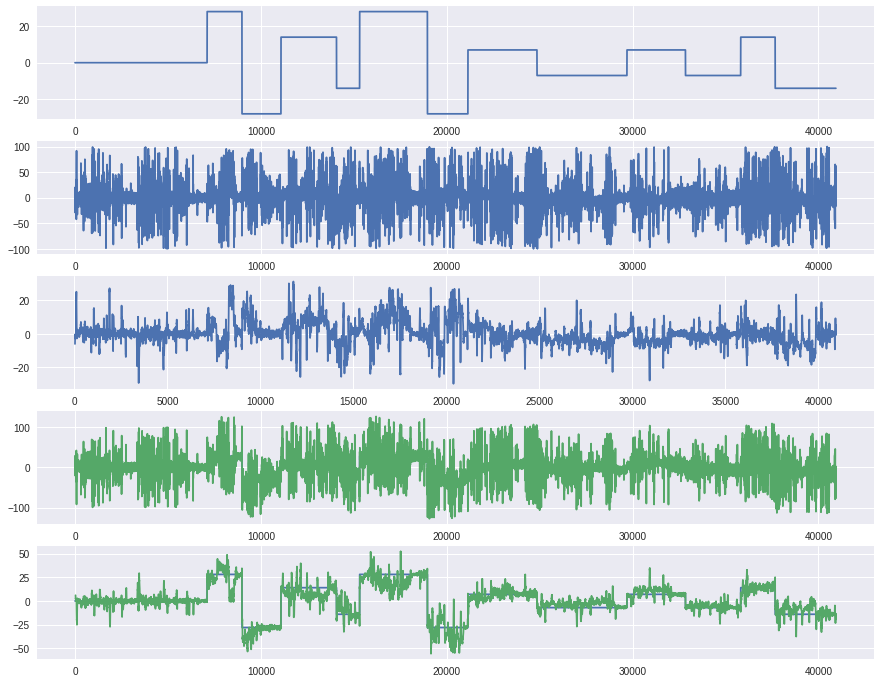

In [12]:
## Plotting based on amount of samples not time
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

r = range(0, len(dfV))

c2 = ax1.plot(r, dfV.speed)
c1 = ax2.plot(r, dfV.U)
c4 = ax3.plot(r, dfV.M)
c3 = ax4.plot(r, dfV.speed, r, dfV.subU)
c5 = ax5.plot(r, dfV.speed, r, dfV.subM)


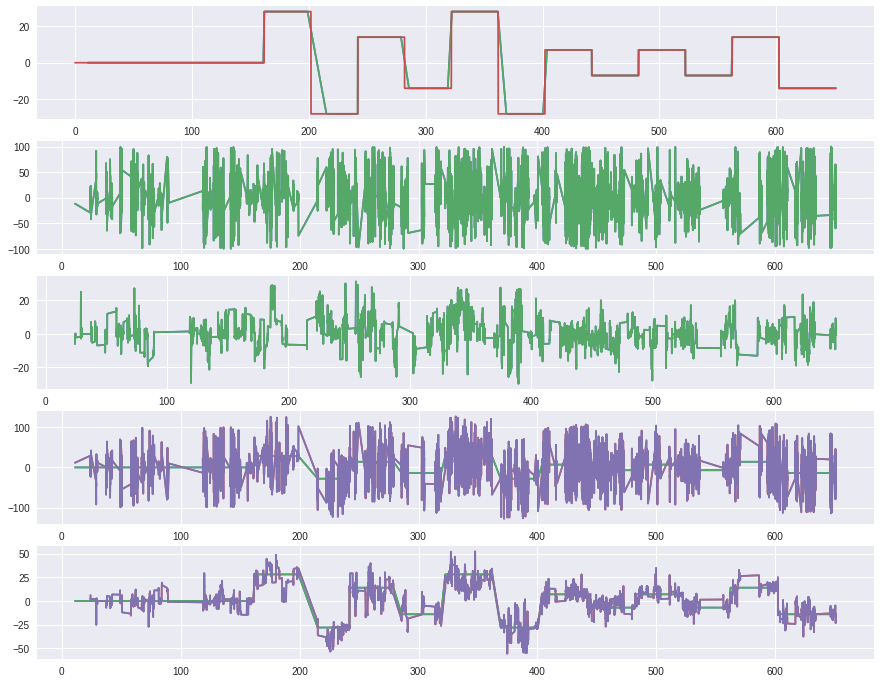

In [13]:
## Plotting
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

#c2 = ax1.plot(dfV.Time, dfV.speed, linestyle='none', marker='o')

c2 = ax1.plot(dfV.Time, dfV.speed, event[i].Time, event[i].speed)
c1 = ax2.plot(dfV.Time, dfV.U)
c4 = ax3.plot(dfV.Time, dfV.M)
c3 = ax4.plot(dfV.Time, dfV.speed, dfV.Time, dfV.subU)
c5 = ax5.plot(dfV.Time, dfV.speed, dfV.Time, dfV.subM)


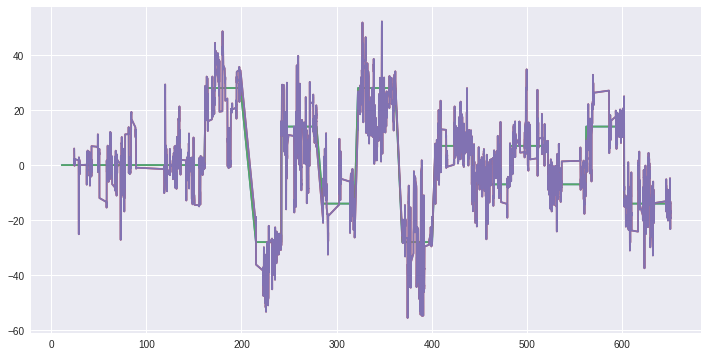

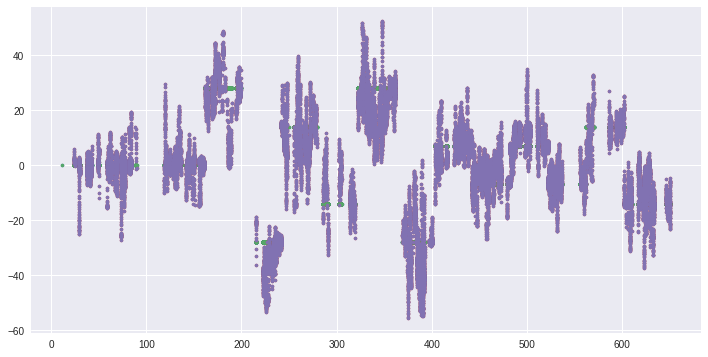

In [14]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
c5 = ax1.plot(dfV.Time, dfV.speed, dfV.Time, dfV.subM)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
c5 = ax1.plot(dfV.Time, dfV.speed, dfV.Time, dfV.subM, linestyle='none', marker='.')


## Stimulus-related behavior
Looking for frames detected as SRB. According to:


In [15]:
# creation of needed dataset
dfSRB = dfV.copy()
dfSRB.drop({'MotiveExpTimeSecs', 'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1', 'lz1', 'V1',
                'thetaOrig', 'theta', 'UOrig', 'M', 'corr','corrM', 'subU', }, axis=1, inplace=True)

dfSRB.dropna(inplace=True)


VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU
stimulus-related behavior: 6.480237%
SRM when stimuli is visible: 8.797044%
SRM when stimuli is invisible: 1.526542%


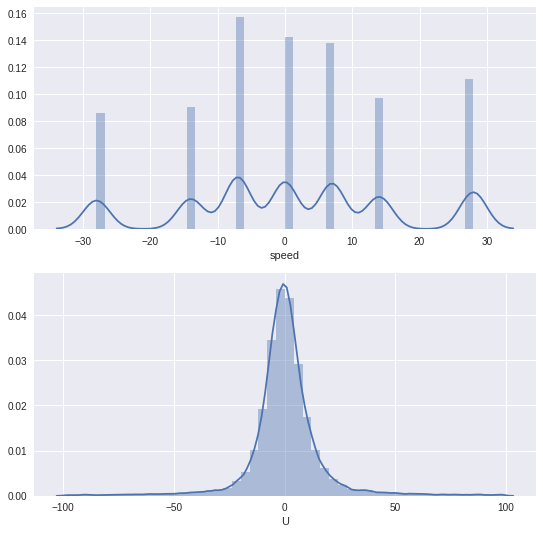

In [16]:
 # setting Dmax as 20% of velocity at given moment // what about 0
dfSRB['Dmax'] = dfSRB.apply(lambda row: row.speed * hyperparam['DmaxPerc'], axis=1)
dfSRB['Dmax'] = dfSRB.apply(lambda row: 0.1 if row.Dmax == 0 else row.Dmax, axis=1)
dfSRB['SRB']  = dfSRB.apply(lambda row: np.absolute(row.subM) < np.absolute(row.Dmax), axis=1)

# checking lenght of SRB frames in the filtered experiment data
sumSRB = len(dfSRB[dfSRB['SRB']])

#  temp dataframes with stimuli being present or not
dfSRBVis = dfSRB[dfSRB['visible']]
dfSRBInvis = dfSRB[~dfSRB['visible']]

sumSRBVis   = len(dfSRBVis[dfSRBVis['SRB']])
sumSRBInvis = len(dfSRBInvis[dfSRBInvis['SRB']])
 
print(fname[i])
print('stimulus-related behavior: %f%%'     % (sumSRB      * 100 / len(dfSRB)     ))
print('SRM when stimuli is visible: %f%%'   % (sumSRBVis   * 100 / len(dfSRBVis)  ))
print('SRM when stimuli is invisible: %f%%' % (sumSRBInvis * 100 / len(dfSRBInvis)))

pd.set_option('display.max_rows', 2000)
#print(dfSRB[dfSRB['SRB']])

# analysis of the stimuli per speed 
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(dfSRB.speed, ax=ax1)
sns.distplot(dfSRB.U    , ax=ax2)